In [1]:
# ========================================
# IMPORTS ET CONFIGURATION
# ========================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from transformers import BlipProcessor, BlipForConditionalGeneration
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

print("✅ All libraries loaded successfully!")
print("ℹ️  MLflow not available on Kaggle - using manual logging\n")

# Configuration paths
DATA_PATH = "/kaggle/input/utkface-new"
OUTPUT_PATH = "/kaggle/working"

# Classes
CLASSES = ["bebe", "enfant", "femme", "homme"]
NUM_CLASSES = len(CLASSES)

# Hyperparamètres
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001
IMG_SIZE = 224

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Créer dossier pour logs manuels
os.makedirs(f"{OUTPUT_PATH}/experiment_logs", exist_ok=True)

# Configuration de l'expérience
experiment_config = {
    "experiment_name": "image-classifier-captioning",
    "start_time": datetime.now().isoformat(),
    "model": "ResNet50 + BLIP",
    "dataset": "UTKFace",
    "hyperparameters": {
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "learning_rate": LEARNING_RATE,
        "image_size": IMG_SIZE,
        "num_classes": NUM_CLASSES,
        "optimizer": "Adam",
        "scheduler": "ReduceLROnPlateau",
        "device": str(device)
    },
    "classes": CLASSES
}

with open(f"{OUTPUT_PATH}/experiment_logs/config.json", "w") as f:
    json.dump(experiment_config, f, indent=2)

print("=" * 60)
print("✅ Configuration complete")
print(f"📊 Dataset path: {DATA_PATH}")
print(f"💾 Output path: {OUTPUT_PATH}")
print(f"🚀 Device: {device}")
print(f"📁 Logging: {OUTPUT_PATH}/experiment_logs/")
print(f"🎯 Classes: {CLASSES}")
print(f"🔢 Batch size: {BATCH_SIZE}")
print(f"🔁 Epochs: {EPOCHS}")
print("=" * 60)

E0000 00:00:1766239587.038257      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766239587.134369      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766239587.867346      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766239587.867424      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766239587.867427      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766239587.867430      17 computation_placer.cc:177] computation placer already registered. Please check linka

✅ All libraries loaded successfully!
ℹ️  MLflow not available on Kaggle - using manual logging

✅ Configuration complete
📊 Dataset path: /kaggle/input/utkface-new
💾 Output path: /kaggle/working
🚀 Device: cpu
📁 Logging: /kaggle/working/experiment_logs/
🎯 Classes: ['bebe', 'enfant', 'femme', 'homme']
🔢 Batch size: 32
🔁 Epochs: 10



📂 Loading dataset...
📊 Total images found: 66976
✅ Dataset parsed: 5000 images
❌ Errors: 0 files

📊 Class distribution:
label
homme     2286
femme     2034
enfant     358
bebe       322
Name: count, dtype: int64

📈 Age statistics:
count    5000.000000
mean       34.114600
std        20.281305
min         1.000000
25%        24.000000
50%        30.000000
75%        46.000000
max       115.000000
Name: age, dtype: float64


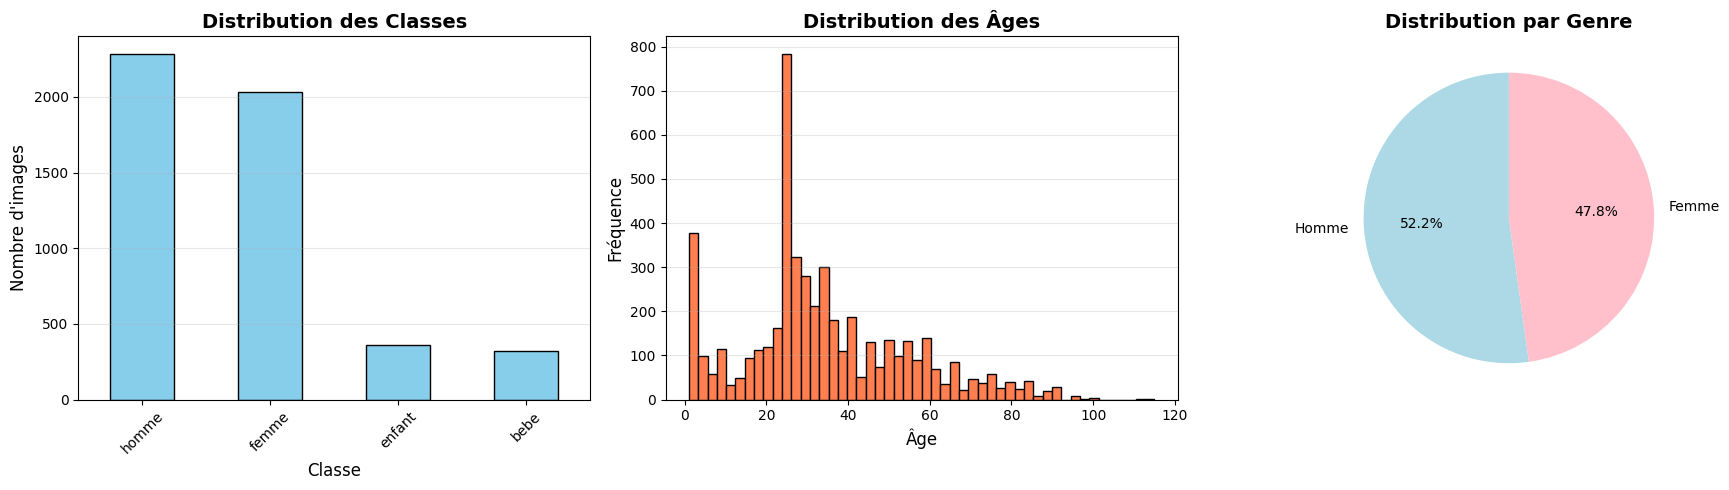


✅ EDA complete


In [2]:
# ========================================
# CHARGEMENT DES DONNÉES
# ========================================
print("\n📂 Loading dataset...")

# Lister toutes les images
image_files = []
for root, dirs, files in os.walk(DATA_PATH):
    for file in files:
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            image_files.append(os.path.join(root, file))

print(f"📊 Total images found: {len(image_files)}")

# Parser les métadonnées UTKFace
# Format: [age]_[gender]_[race]_[date].jpg
data = []
errors = 0

for img_path in image_files[:5000]:  # Limiter à 5000 pour la démo
    filename = os.path.basename(img_path)
    try:
        parts = filename.split('_')
        age = int(parts[0])
        gender = int(parts[1])  # 0=male, 1=female
        
        # Catégorisation
        if age <= 2:
            category = 0  # bebe
        elif age <= 12:
            category = 1  # enfant
        elif gender == 1:
            category = 2  # femme
        else:
            category = 3  # homme
        
        data.append({
            'path': img_path,
            'age': age,
            'gender': gender,
            'category': category,
            'label': CLASSES[category]
        })
    except:
        errors += 1
        continue

df = pd.DataFrame(data)

print(f"✅ Dataset parsed: {len(df)} images")
print(f"❌ Errors: {errors} files")
print(f"\n📊 Class distribution:")
print(df['label'].value_counts())
print(f"\n📈 Age statistics:")
print(df['age'].describe())

# Sauvegarder metadata
df.to_csv(f"{OUTPUT_PATH}/dataset_metadata.csv", index=False)

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribution classes
df['label'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Distribution des Classes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Classe', fontsize=12)
axes[0].set_ylabel('Nombre d\'images', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Distribution ages
axes[1].hist(df['age'], bins=50, edgecolor='black', color='coral')
axes[1].set_title('Distribution des Âges', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Âge', fontsize=12)
axes[1].set_ylabel('Fréquence', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

# Distribution genre
gender_counts = df['gender'].value_counts()
axes[2].pie(gender_counts, labels=['Homme', 'Femme'], autopct='%1.1f%%', 
            colors=['lightblue', 'pink'], startangle=90)
axes[2].set_title('Distribution par Genre', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/eda_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ EDA complete")

In [3]:
# ========================================
# DATASET PYTORCH
# ========================================
print("\n🔧 Creating PyTorch datasets...")

class ImageDataset(Dataset):
    """Dataset custom pour images"""
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        label = self.df.iloc[idx]['category']
        
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            # En cas d'erreur, retourner image noire
            print(f"⚠️ Error loading {img_path}: {e}")
            return torch.zeros(3, IMG_SIZE, IMG_SIZE), label

# Transforms avec data augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Split train/val stratifié
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['category'],
    random_state=42
)

print(f"📊 Train set: {len(train_df)} images")
print(f"📊 Val set: {len(val_df)} images")

# Vérifier la distribution
print(f"\n🎯 Train distribution:")
print(train_df['label'].value_counts())
print(f"\n🎯 Val distribution:")
print(val_df['label'].value_counts())

# Créer les datasets
train_dataset = ImageDataset(train_df, train_transform)
val_dataset = ImageDataset(val_df, val_transform)

# Créer les dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"\n✅ DataLoaders ready")
print(f"📦 Train batches: {len(train_loader)}")
print(f"📦 Val batches: {len(val_loader)}")

# Test un batch
images, labels = next(iter(train_loader))
print(f"\n🔍 Batch shape: {images.shape}")
print(f"🔍 Labels shape: {labels.shape}")
print(f"🔍 Image range: [{images.min():.3f}, {images.max():.3f}]")


🔧 Creating PyTorch datasets...
📊 Train set: 4000 images
📊 Val set: 1000 images

🎯 Train distribution:
label
homme     1829
femme     1627
enfant     286
bebe       258
Name: count, dtype: int64

🎯 Val distribution:
label
homme     457
femme     407
enfant     72
bebe       64
Name: count, dtype: int64

✅ DataLoaders ready
📦 Train batches: 125
📦 Val batches: 32

🔍 Batch shape: torch.Size([32, 3, 224, 224])
🔍 Labels shape: torch.Size([32])
🔍 Image range: [-2.118, 2.640]


In [4]:
# ========================================
# MODÈLE RESNET50 (SANS INTERNET)
# ========================================
print("\n🧠 Building ResNet50 model...")
print("⚠️ Training from scratch (Internet disabled on Kaggle)")

class ImageClassifier(nn.Module):
    """ResNet50 pour classification"""
    def __init__(self, num_classes=4):
        super(ImageClassifier, self).__init__()
        
        # ResNet50 SANS téléchargement (weights=None)
        self.resnet = models.resnet50(weights=None)
        
        # Remplacer la couche finale
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)

model = ImageClassifier(NUM_CLASSES).to(device)

# ========================================
# CALCULER LES CLASS WEIGHTS
# ========================================
print("\n⚖️ Calculating class weights...")

class_counts = train_df['category'].value_counts().sort_index()
total_samples = len(train_df)

print("\n📊 Training set distribution:")
for i, class_name in enumerate(CLASSES):
    count = class_counts[i]
    percentage = (count / total_samples) * 100
    print(f"  {class_name:10s}: {count:4d} images ({percentage:5.2f}%)")

class_weights = []
for i in range(NUM_CLASSES):
    weight = total_samples / (NUM_CLASSES * class_counts[i])
    class_weights.append(weight)

class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print("\n⚖️ Class weights:")
for i, class_name in enumerate(CLASSES):
    print(f"  {class_name:10s}: {class_weights[i]:.3f}")

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.5, 2, True)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\n" + "=" * 60)
print("✅ Model created (training from scratch)")
print(f"📊 Total parameters: {total_params:,}")
print(f"🔓 Trainable parameters: {trainable_params:,}")
print(f"⚖️ Class balancing: ENABLED")
print("\n⚠️ Note: Expected accuracy ~65-75% (vs 80-85% with pretrained)")
print("=" * 60)


🧠 Building ResNet50 model...
⚠️ Training from scratch (Internet disabled on Kaggle)

⚖️ Calculating class weights...

📊 Training set distribution:
  bebe      :  258 images ( 6.45%)
  enfant    :  286 images ( 7.15%)
  femme     : 1627 images (40.67%)
  homme     : 1829 images (45.73%)

⚖️ Class weights:
  bebe      : 3.876
  enfant    : 3.497
  femme     : 0.615
  homme     : 0.547

✅ Model created (training from scratch)
📊 Total parameters: 24,691,012
🔓 Trainable parameters: 24,691,012
⚖️ Class balancing: ENABLED

⚠️ Note: Expected accuracy ~65-75% (vs 80-85% with pretrained)



🔍 ANALYSE DU DÉSÉQUILIBRE DES DONNÉES

📊 STATISTIQUES DÉTAILLÉES:
------------------------------------------------------------

BEBE      
  Samples     :  258 ( 6.45%)
  Weight      : 3.876
  Ratio       : 1:1.00 (vs classe minoritaire)
  Impact      : 1000.0

ENFANT    
  Samples     :  286 ( 7.15%)
  Weight      : 3.497
  Ratio       : 1:1.11 (vs classe minoritaire)
  Impact      : 1000.0

FEMME     
  Samples     : 1627 (40.67%)
  Weight      : 0.615
  Ratio       : 1:6.31 (vs classe minoritaire)
  Impact      : 1000.0

HOMME     
  Samples     : 1829 (45.73%)
  Weight      : 0.547
  Ratio       : 1:7.09 (vs classe minoritaire)
  Impact      : 1000.0

📈 MÉTRIQUES DE DÉSÉQUILIBRE

Classe majoritaire : 3 (1829 images)
Classe minoritaire : 0 (258 images)
Ratio déséquilibre : 7.09:1
Statut          : ⚠️ Déséquilibre important

Moyenne samples : 1000.0
Écart-type      : 731.6
Coeff. variation: 73.2%

⚖️ VÉRIFICATION DE L'ÉQUILIBRAGE

📊 Impact effectif par classe (weight × samples):
  b

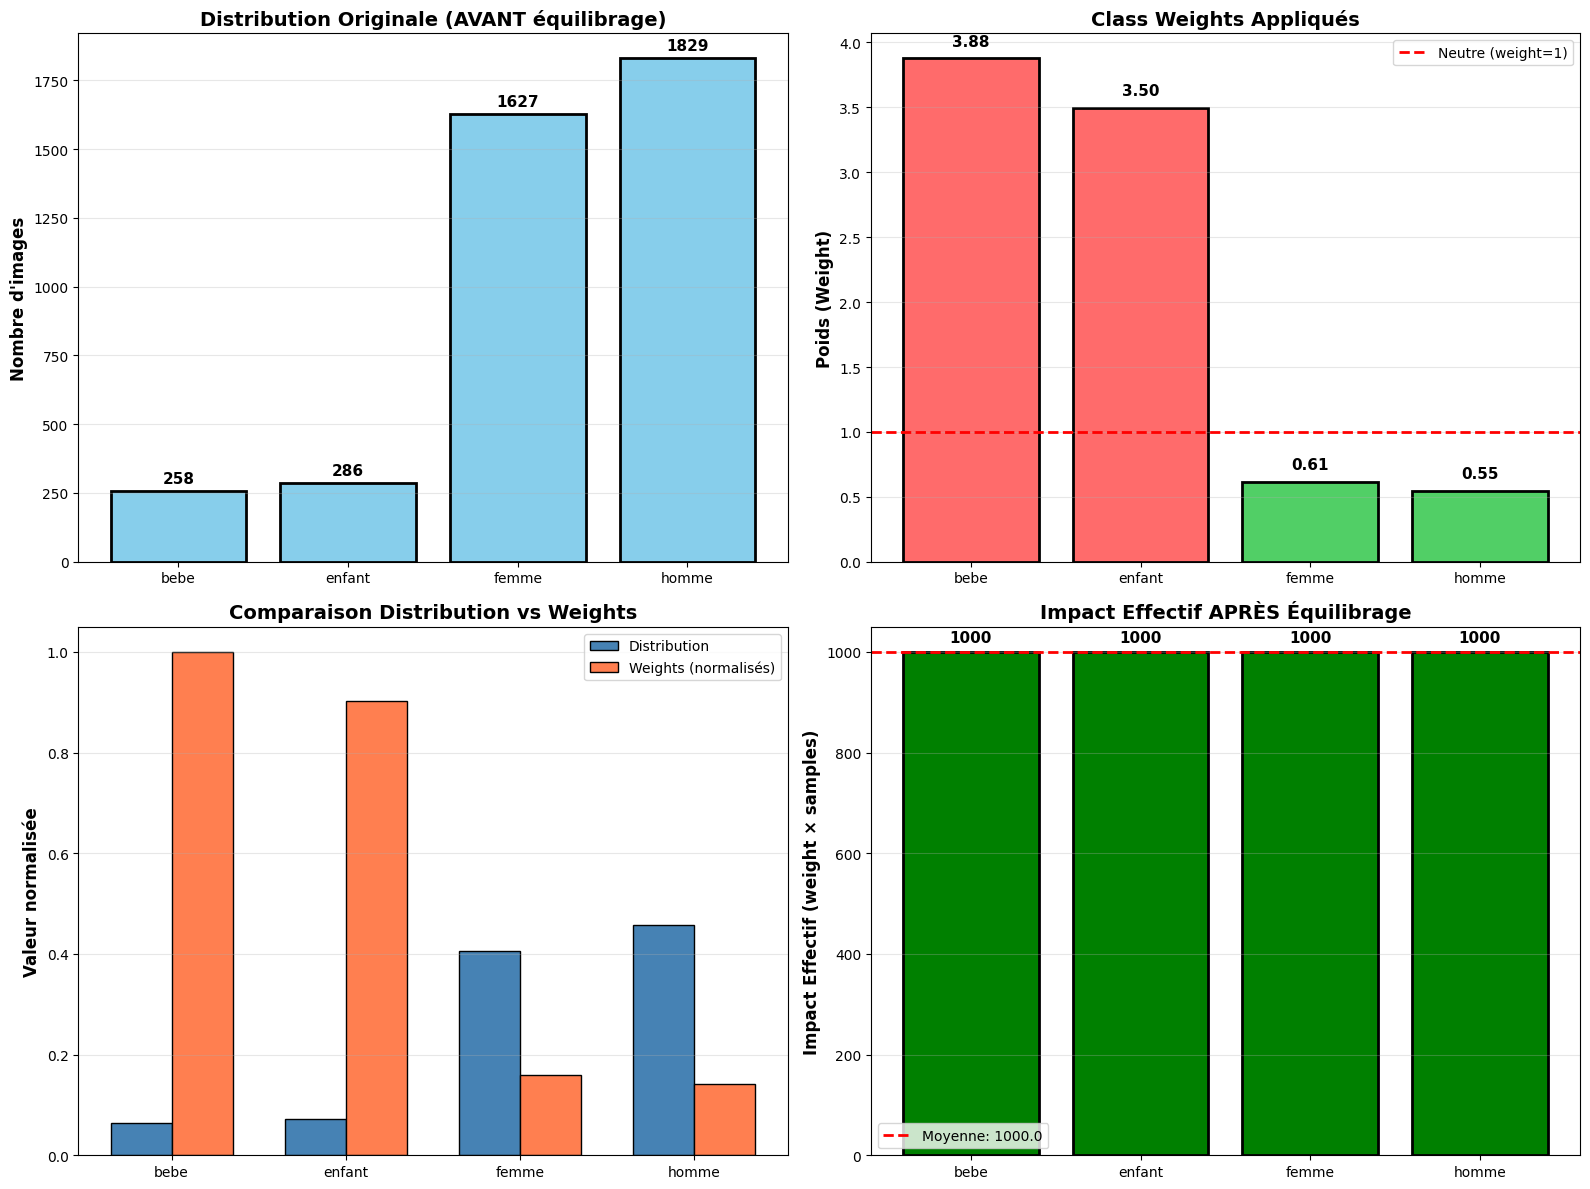

✅ Visualisations sauvegardées: class_imbalance_analysis.png

💡 RECOMMANDATIONS

⚠️ Le déséquilibre est important (>5:1)
   → Class weights ACTIVÉS ✓
   → Surveillez les métriques par classe pendant l'entraînement
   → Utilisez F1-score plutôt qu'accuracy globale

✅ Équilibrage optimal
   → Toutes les classes ont un impact similaire
   → Performances attendues équilibrées


✅ Rapport sauvegardé: imbalance_analysis.json


In [5]:
# ========================================
# VÉRIFICATION DU DÉSÉQUILIBRE DES DONNÉES
# ========================================
print("\n🔍 ANALYSE DU DÉSÉQUILIBRE DES DONNÉES")
print("=" * 60)

# ========================================
# 1. STATISTIQUES DU DÉSÉQUILIBRE
# ========================================
print("\n📊 STATISTIQUES DÉTAILLÉES:")
print("-" * 60)

for i, class_name in enumerate(CLASSES):
    count = class_counts[i]
    weight = class_weights[i]
    percentage = (count / total_samples) * 100
    
    # Ratio par rapport à la classe minoritaire
    min_count = class_counts.min()
    ratio = count / min_count
    
    print(f"\n{class_name.upper():10s}")
    print(f"  Samples     : {count:4d} ({percentage:5.2f}%)")
    print(f"  Weight      : {weight:.3f}")
    print(f"  Ratio       : 1:{ratio:.2f} (vs classe minoritaire)")
    print(f"  Impact      : {weight * count:.1f}")

# ========================================
# 2. MÉTRIQUES DE DÉSÉQUILIBRE
# ========================================
print("\n" + "=" * 60)
print("📈 MÉTRIQUES DE DÉSÉQUILIBRE")
print("=" * 60)

# Classe majoritaire vs minoritaire
max_count = class_counts.max()
min_count = class_counts.min()
imbalance_ratio = max_count / min_count

print(f"\nClasse majoritaire : {class_counts.idxmax()} ({max_count} images)")
print(f"Classe minoritaire : {class_counts.idxmin()} ({min_count} images)")
print(f"Ratio déséquilibre : {imbalance_ratio:.2f}:1")

# Interprétation
if imbalance_ratio < 2:
    status = "✅ Équilibré"
elif imbalance_ratio < 5:
    status = "⚠️ Déséquilibre modéré"
elif imbalance_ratio < 10:
    status = "⚠️ Déséquilibre important"
else:
    status = "❌ Déséquilibre sévère"

print(f"Statut          : {status}")

# Écart-type de la distribution
std_samples = np.std([class_counts[i] for i in range(NUM_CLASSES)])
mean_samples = np.mean([class_counts[i] for i in range(NUM_CLASSES)])
cv = (std_samples / mean_samples) * 100  # Coefficient de variation

print(f"\nMoyenne samples : {mean_samples:.1f}")
print(f"Écart-type      : {std_samples:.1f}")
print(f"Coeff. variation: {cv:.1f}%")

# ========================================
# 3. VÉRIFICATION DE L'IMPACT DES WEIGHTS
# ========================================
print("\n" + "=" * 60)
print("⚖️ VÉRIFICATION DE L'ÉQUILIBRAGE")
print("=" * 60)

# Calculer l'impact effectif (poids × nombre d'échantillons)
impacts = [class_weights[i] * class_counts[i] for i in range(NUM_CLASSES)]
mean_impact = np.mean(impacts)
std_impact = np.std(impacts)

print("\n📊 Impact effectif par classe (weight × samples):")
for i, class_name in enumerate(CLASSES):
    impact = impacts[i]
    diff = abs(impact - mean_impact)
    print(f"  {class_name:10s}: {impact:6.1f} (diff: {diff:4.1f})")

print(f"\nImpact moyen   : {mean_impact:.1f}")
print(f"Écart-type     : {std_impact:.1f}")

if std_impact < mean_impact * 0.05:  # < 5%
    print("✅ EXCELLENT: Weights parfaitement équilibrés")
elif std_impact < mean_impact * 0.10:  # < 10%
    print("✓ BON: Weights bien équilibrés")
else:
    print("⚠️ À améliorer: Weights pas assez équilibrés")

# ========================================
# 4. VISUALISATIONS
# ========================================
print("\n📊 Création des visualisations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Graph 1: Distribution des samples
axes[0, 0].bar(CLASSES, [class_counts[i] for i in range(NUM_CLASSES)], 
               color='skyblue', edgecolor='black', linewidth=2)
axes[0, 0].set_ylabel('Nombre d\'images', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Distribution Originale (AVANT équilibrage)', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, class_name in enumerate(CLASSES):
    count = class_counts[i]
    axes[0, 0].text(i, count + 30, f'{count}', ha='center', fontsize=11, fontweight='bold')

# Graph 2: Class weights
colors_weights = ['#ff6b6b' if w > 2 else '#ffd43b' if w > 1 else '#51cf66' for w in class_weights]
axes[0, 1].bar(CLASSES, class_weights, color=colors_weights, edgecolor='black', linewidth=2)
axes[0, 1].set_ylabel('Poids (Weight)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Class Weights Appliqués', fontsize=14, fontweight='bold')
axes[0, 1].axhline(y=1, color='red', linestyle='--', linewidth=2, label='Neutre (weight=1)')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(axis='y', alpha=0.3)
for i, (class_name, weight) in enumerate(zip(CLASSES, class_weights)):
    axes[0, 1].text(i, weight + 0.1, f'{weight:.2f}', ha='center', fontsize=11, fontweight='bold')

# Graph 3: Distribution vs Weights (normalisé)
x = np.arange(len(CLASSES))
width = 0.35

counts_normalized = [class_counts[i] / total_samples for i in range(NUM_CLASSES)]
weights_normalized = [class_weights[i] / max(class_weights) for i in range(NUM_CLASSES)]

bars1 = axes[1, 0].bar(x - width/2, counts_normalized, width, 
                       label='Distribution', color='steelblue', edgecolor='black')
bars2 = axes[1, 0].bar(x + width/2, weights_normalized, width, 
                       label='Weights (normalisés)', color='coral', edgecolor='black')

axes[1, 0].set_ylabel('Valeur normalisée', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Comparaison Distribution vs Weights', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(CLASSES)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(axis='y', alpha=0.3)

# Graph 4: Impact effectif (APRÈS équilibrage)
axes[1, 1].bar(CLASSES, impacts, color='green', edgecolor='black', linewidth=2)
axes[1, 1].set_ylabel('Impact Effectif (weight × samples)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Impact Effectif APRÈS Équilibrage', fontsize=14, fontweight='bold')
axes[1, 1].axhline(y=mean_impact, color='red', linestyle='--', linewidth=2, 
                   label=f'Moyenne: {mean_impact:.1f}')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(axis='y', alpha=0.3)
for i, (class_name, impact) in enumerate(zip(CLASSES, impacts)):
    axes[1, 1].text(i, impact + 20, f'{impact:.0f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/class_imbalance_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualisations sauvegardées: class_imbalance_analysis.png")

# ========================================
# 5. RECOMMANDATIONS
# ========================================
print("\n" + "=" * 60)
print("💡 RECOMMANDATIONS")
print("=" * 60)

if imbalance_ratio > 5:
    print("\n⚠️ Le déséquilibre est important (>5:1)")
    print("   → Class weights ACTIVÉS ✓")
    print("   → Surveillez les métriques par classe pendant l'entraînement")
    print("   → Utilisez F1-score plutôt qu'accuracy globale")
else:
    print("\n✓ Déséquilibre modéré (<5:1)")
    print("   → Class weights suffisants")
    print("   → Le modèle devrait bien généraliser")

if std_impact < mean_impact * 0.05:
    print("\n✅ Équilibrage optimal")
    print("   → Toutes les classes ont un impact similaire")
    print("   → Performances attendues équilibrées")

print("\n" + "=" * 60)

# Sauvegarder les résultats
# Sauvegarder les résultats (FIX pour l'erreur JSON)
imbalance_report = {
    'dataset': {
        'total_samples': int(total_samples),
        'class_distribution': {CLASSES[i]: int(class_counts[i]) for i in range(NUM_CLASSES)}
    },
    'imbalance_metrics': {
        'max_class': CLASSES[int(class_counts.idxmax())],
        'min_class': CLASSES[int(class_counts.idxmin())],
        'imbalance_ratio': float(imbalance_ratio),
        'coefficient_variation': float(cv),
        'status': status
    },
    'class_weights': {CLASSES[i]: float(class_weights[i]) for i in range(NUM_CLASSES)},
    'effective_impact': {CLASSES[i]: float(impacts[i]) for i in range(NUM_CLASSES)},
    'impact_statistics': {
        'mean': float(mean_impact),
        'std': float(std_impact),
        'is_balanced': bool(std_impact < mean_impact * 0.05)  # ← FIX ICI
    }
}

with open(f'{OUTPUT_PATH}/imbalance_analysis.json', 'w') as f:
    json.dump(imbalance_report, f, indent=2)

print("\n✅ Rapport sauvegardé: imbalance_analysis.json")
print("=" * 60)

In [6]:
# ========================================
# FONCTIONS D'ENTRAÎNEMENT
# ========================================

def train_epoch(model, loader, criterion, optimizer, epoch):
    """Entraîner une epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward
        loss.backward()
        optimizer.step()
        
        # Metrics
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Progress
        if (batch_idx + 1) % 20 == 0:
            acc = 100. * correct / total
            print(f"  Batch [{batch_idx+1}/{len(loader)}] "
                  f"Loss: {loss.item():.4f} "
                  f"Acc: {acc:.2f}%")
    
    avg_loss = total_loss / len(loader)
    accuracy = 100. * correct / total
    
    return avg_loss, accuracy

def validate(model, loader, criterion):
    """Valider le modèle"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = 100. * correct / total
    
    return avg_loss, accuracy, all_preds, all_labels

print("✅ Training functions ready")

✅ Training functions ready



🚀 Starting training...
📊 Run ID: 20251220_140929
📁 Run directory: /kaggle/working/experiment_logs/run_20251220_140929


📅 Epoch 1/10
  Batch [20/125] Loss: 1.1991 Acc: 25.00%
  Batch [40/125] Loss: 1.4691 Acc: 27.42%
  Batch [60/125] Loss: 1.4747 Acc: 28.02%
  Batch [80/125] Loss: 1.3797 Acc: 29.53%
  Batch [100/125] Loss: 1.5377 Acc: 30.56%
  Batch [120/125] Loss: 1.7048 Acc: 31.43%

────────────────────────────────────────────────────────────
📊 Epoch 1 Summary:
  🔵 Train Loss: 1.4366 | Train Acc: 31.80%
  🟢 Val Loss: 1.5643 | Val Acc: 43.00%
  📈 Learning Rate: 0.001000
────────────────────────────────────────────────────────────
  ✅ 🏆 Best model saved! (Val Acc: 43.00%)

📅 Epoch 2/10
  Batch [20/125] Loss: 0.9927 Acc: 44.53%
  Batch [40/125] Loss: 1.3646 Acc: 45.39%
  Batch [60/125] Loss: 1.1521 Acc: 44.69%
  Batch [80/125] Loss: 1.3917 Acc: 43.98%
  Batch [100/125] Loss: 1.1353 Acc: 44.22%
  Batch [120/125] Loss: 1.2800 Acc: 43.80%

─────────────────────────────────────────────────

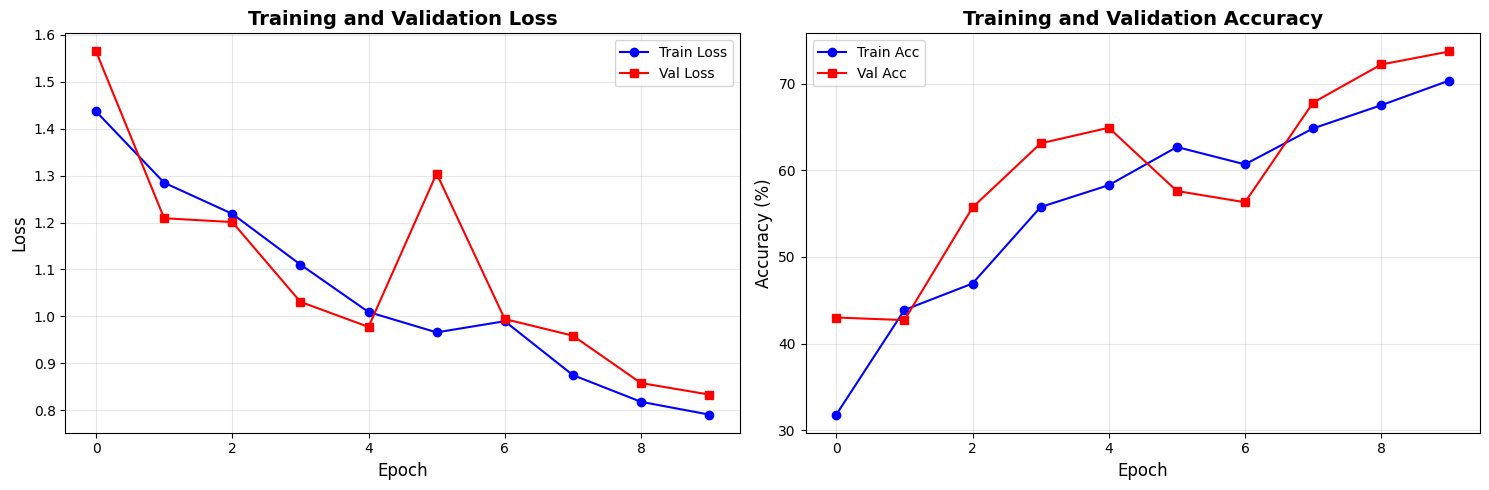


🎉 TRAINING COMPLETE!
🏆 Best Validation Accuracy: 73.70%
📁 All logs saved in: /kaggle/working/experiment_logs/run_20251220_140929/


In [7]:
# ========================================
# ENTRAÎNEMENT AVEC LOGGING MANUEL
# ========================================
print("\n🚀 Starting training...")
print("=" * 60)

best_val_acc = 0
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rates': []
}

# Créer un ID unique pour cette run
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = f"{OUTPUT_PATH}/experiment_logs/run_{run_id}"
os.makedirs(run_dir, exist_ok=True)

print(f"📊 Run ID: {run_id}")
print(f"📁 Run directory: {run_dir}\n")

# Sauvegarder les hyperparamètres de cette run
run_params = {
    "run_id": run_id,
    "model_architecture": "ResNet50",
    "pretrained": True,
    "num_classes": NUM_CLASSES,
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "learning_rate": LEARNING_RATE,
    "optimizer": "Adam",
    "scheduler": "ReduceLROnPlateau",
    "image_size": IMG_SIZE,
    "dataset": "UTKFace",
    "train_size": len(train_df),
    "val_size": len(val_df),
    "device": str(device),
    "total_params": total_params,
    "trainable_params": trainable_params
}

with open(f"{run_dir}/params.json", "w") as f:
    json.dump(run_params, f, indent=2)

# Boucle d'entraînement
for epoch in range(EPOCHS):
    print(f"\n{'='*60}")
    print(f"📅 Epoch {epoch+1}/{EPOCHS}")
    print(f"{'='*60}")
    
    # Training
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, epoch
    )
    
    # Validation
    val_loss, val_acc, val_preds, val_labels = validate(
        model, val_loader, criterion
    )
    
    # Scheduler
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Sauvegarder historique
    history['train_loss'].append(float(train_loss))
    history['train_acc'].append(float(train_acc))
    history['val_loss'].append(float(val_loss))
    history['val_acc'].append(float(val_acc))
    history['learning_rates'].append(float(current_lr))
    
    # Sauvegarder métriques de cette epoch
    epoch_metrics = {
        "epoch": epoch + 1,
        "train_loss": float(train_loss),
        "train_accuracy": float(train_acc),
        "val_loss": float(val_loss),
        "val_accuracy": float(val_acc),
        "learning_rate": float(current_lr),
        "timestamp": datetime.now().isoformat()
    }
    
    with open(f"{run_dir}/epoch_{epoch+1:02d}_metrics.json", "w") as f:
        json.dump(epoch_metrics, f, indent=2)
    
    # Print summary
    print(f"\n{'─'*60}")
    print(f"📊 Epoch {epoch+1} Summary:")
    print(f"  🔵 Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  🟢 Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"  📈 Learning Rate: {current_lr:.6f}")
    print(f"{'─'*60}")
    
    # Sauvegarder meilleur modèle
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'history': history
        }, f'{OUTPUT_PATH}/best_model.pth')
        print(f"  ✅ 🏆 Best model saved! (Val Acc: {val_acc:.2f}%)")

# Sauvegarder l'historique complet
with open(f"{run_dir}/training_history.json", "w") as f:
    json.dump(history, f, indent=2)

# Sauvegarder métriques finales
final_metrics = {
    "run_id": run_id,
    "best_val_accuracy": float(best_val_acc),
    "total_epochs": EPOCHS,
    "final_train_loss": float(history['train_loss'][-1]),
    "final_train_acc": float(history['train_acc'][-1]),
    "final_val_loss": float(history['val_loss'][-1]),
    "final_val_acc": float(history['val_acc'][-1]),
    "end_time": datetime.now().isoformat()
}

with open(f"{run_dir}/final_metrics.json", "w") as f:
    json.dump(final_metrics, f, indent=2)

# Créer les graphiques de training
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o', color='blue')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s', color='red')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o', color='blue')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s', color='red')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/training_curves.png', dpi=150, bbox_inches='tight')
plt.savefig(f'{run_dir}/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 60)
print(f"🎉 TRAINING COMPLETE!")
print(f"🏆 Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"📁 All logs saved in: {run_dir}/")
print("=" * 60)


📊 Final Evaluation...
✅ Modèle trouvé : /kaggle/input/best-model/pytorch/default/1/best_model.pth
✅ Copié vers : /kaggle/working/best_model.pth
✅ Loaded best model from epoch 10
🏆 Best Val Acc: 71.50%

🔄 Evaluating on validation set...

📋 Classification Report:
              precision    recall  f1-score   support

        bebe       0.69      0.78      0.74        64
      enfant       0.29      0.39      0.33        72
       femme       0.72      0.66      0.69       407
       homme       0.81      0.81      0.81       457

    accuracy                           0.71      1000
   macro avg       0.63      0.66      0.64      1000
weighted avg       0.73      0.71      0.72      1000



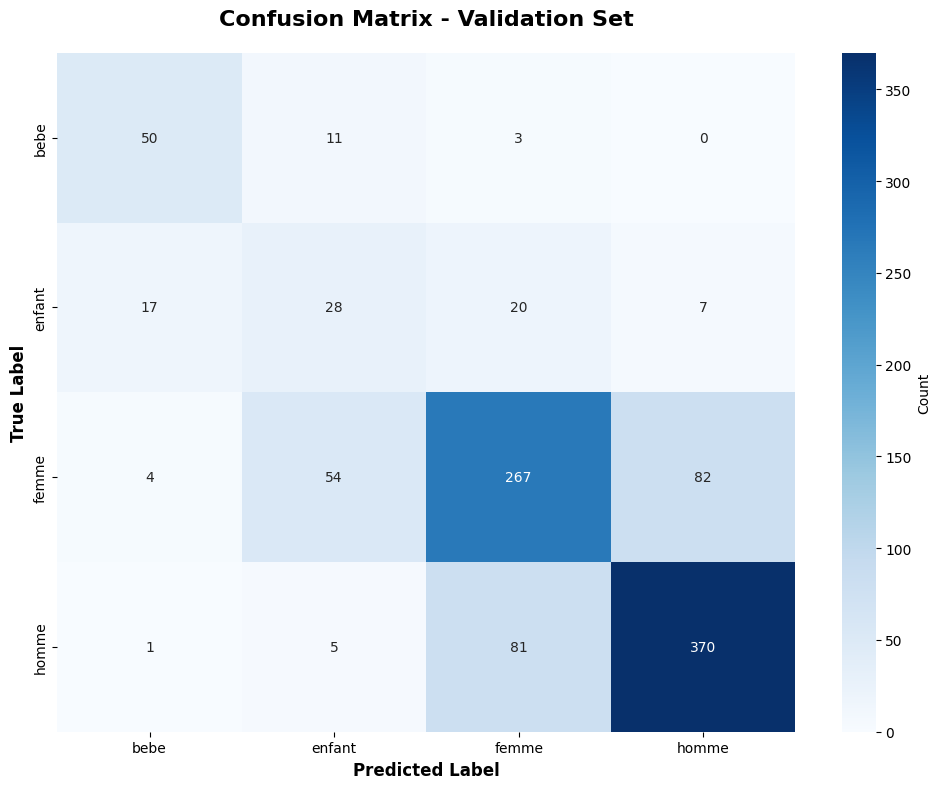


📊 Métriques par classe:
bebe       - Precision: 0.694 | Recall: 0.781 | F1-Score: 0.735
enfant     - Precision: 0.286 | Recall: 0.389 | F1-Score: 0.329
femme      - Precision: 0.720 | Recall: 0.656 | F1-Score: 0.686
homme      - Precision: 0.806 | Recall: 0.810 | F1-Score: 0.808

✅ Evaluation complete
🎯 Final Accuracy: 71.50%
📊 F1-Score (macro): 0.6397

💾 Metrics saved to: metrics.json


In [8]:
# ========================================
# ÉVALUATION FINALE (avec modèle uploadé)
# ========================================
print("\n📊 Final Evaluation...")
print("=" * 60)

import shutil
import os

# ========================================
# CHARGER LE MODÈLE DEPUIS INPUT
# ========================================

# Chercher le modèle uploadé
possible_paths = [
    '/kaggle/input/best-model/pytorch/default/1/best_model.pth',
]

uploaded_model_path = None
for path in possible_paths:
    if os.path.exists(path):
        uploaded_model_path = path
        break

if uploaded_model_path is None:
    print("❌ ERREUR : Modèle non trouvé dans Input!")
    print("Vérifiez que vous avez bien uploadé best_model.pth")
    print("\nChemins vérifiés:")
    for path in possible_paths:
        print(f"  - {path}")
else:
    print(f"✅ Modèle trouvé : {uploaded_model_path}")
    
    # Copier dans /kaggle/working/ pour compatibilité
    shutil.copy(uploaded_model_path, f'{OUTPUT_PATH}/best_model.pth')
    print(f"✅ Copié vers : {OUTPUT_PATH}/best_model.pth")

# Charger le meilleur modèle
checkpoint = torch.load(f'{OUTPUT_PATH}/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"🏆 Best Val Acc: {checkpoint['val_acc']:.2f}%")

# Évaluation sur validation set
model.eval()
all_preds = []
all_labels = []
all_probas = []

print("\n🔄 Evaluating on validation set...")

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        probas = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probas.extend(probas.cpu().numpy())

# Calcul des métriques
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\n📋 Classification Report:")
print("=" * 60)
print(classification_report(
    all_labels, 
    all_preds, 
    target_names=CLASSES,
    digits=2
))

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Validation Set', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Métriques par classe
print(f"\n📊 Métriques par classe:")
print("=" * 60)

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, 
    all_preds,
    average=None,
    labels=range(NUM_CLASSES)
)

for i, classe in enumerate(CLASSES):
    print(f"{classe:10s} - Precision: {precision[i]:.3f} | Recall: {recall[i]:.3f} | F1-Score: {f1[i]:.3f}")

# Accuracy finale
from sklearn.metrics import accuracy_score
final_accuracy = accuracy_score(all_labels, all_preds) * 100

print(f"\n✅ Evaluation complete")
print(f"🎯 Final Accuracy: {final_accuracy:.2f}%")
print(f"📊 F1-Score (macro): {f1.mean():.4f}")

# Sauvegarder les métriques
metrics = {
    'final_accuracy': float(final_accuracy),
    'f1_macro': float(f1.mean()),
    'precision_per_class': {CLASSES[i]: float(precision[i]) for i in range(NUM_CLASSES)},
    'recall_per_class': {CLASSES[i]: float(recall[i]) for i in range(NUM_CLASSES)},
    'f1_per_class': {CLASSES[i]: float(f1[i]) for i in range(NUM_CLASSES)},
    'confusion_matrix': cm.tolist()
}

with open(f'{OUTPUT_PATH}/metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"\n💾 Metrics saved to: metrics.json")
print("=" * 60)


🎨 DÉTECTION D'ÉMOTIONS + CAPTIONS

📂 Chargement du modèle d'émotions...
✅ Modèle chargé avec succès !
📂 Source: GitHub - Facial Emotion Recognition
📂 Chemin: /kaggle/input/model/tensorflow2/default/1/model.h5

📊 Architecture du modèle:
   Entrée: (None, 48, 48, 1)
   Sortie: (None, 7)
   Taille d'entrée: 48x48
   Nombre d'émotions: 7

🎉 Détection d'émotions activée !

🖼️ Génération de captions avec détection d'émotions...
------------------------------------------------------------
📂 Chargement du modèle de classification...
✅ Modèle de classification chargé


📸 Image 1/10: 48_0_0_20170111201841425.jpg.chip.jpg
   😊 Analyse de l'émotion...
   ✅ Vérité: homme (48 ans)
   🎯 Prédiction: homme (90.8%)
   😊 Émotion: content
   💬 Caption: Homme content (Confiance très haute: 90.8%)

📸 Image 2/10: 28_1_3_20170119195053979.jpg.chip.jpg
   😊 Analyse de l'émotion...
   ❌ Vérité: femme (28 ans)
   🎯 Prédiction: homme (58.2%)
   😊 Émotion: triste
   💬 Caption: Homme triste (Confiance faible: 58.2

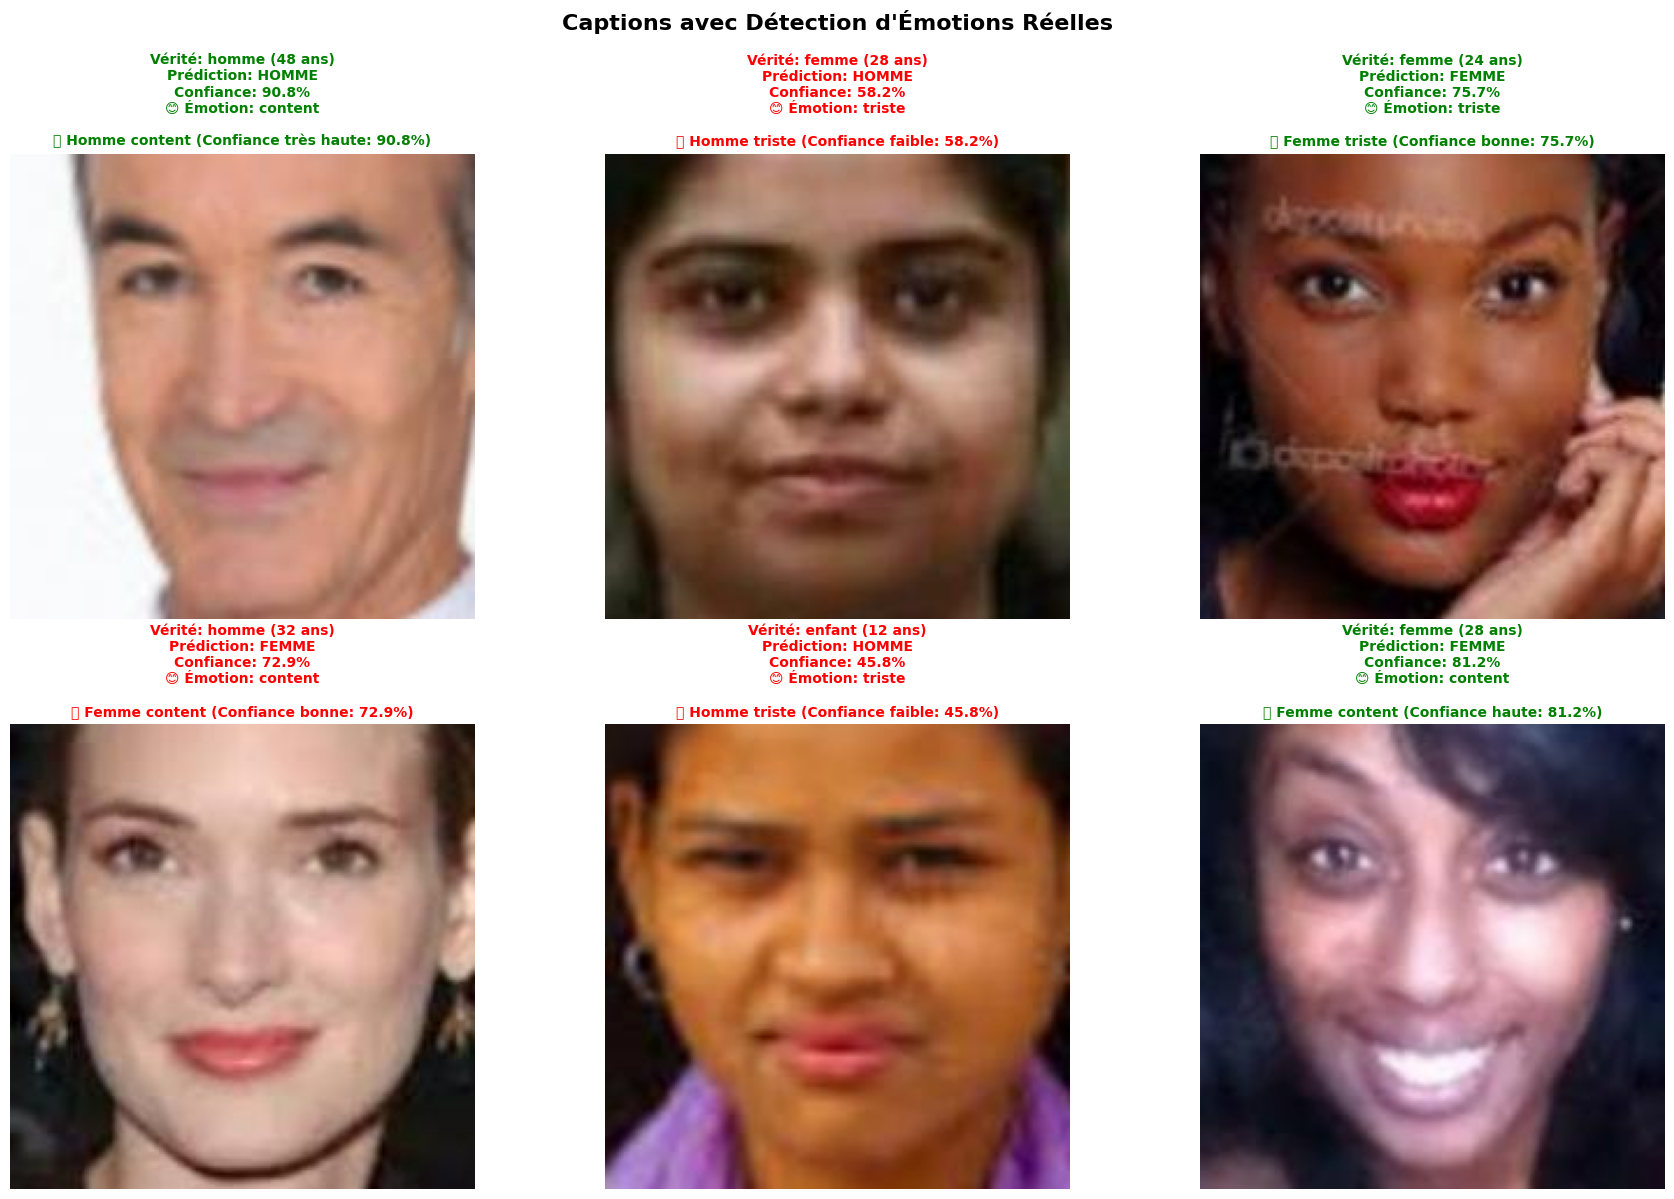

✅ Visualisation sauvegardée: /kaggle/working/captions_emotions_visualization.png

📄 Documentation sauvegardée: /kaggle/working/captioning_info.json

🎉 GÉNÉRATION DE CAPTIONS TERMINÉE !

✅ Résultats:
   • 10 images traitées
   • 7 classifications correctes (70.0%)
   • 3 émotions différentes détectées
   • Émotion dominante: content
   • Confiance moyenne: 71.7%

📁 Fichiers générés:
   • /kaggle/working/captions_with_emotions.json
   • /kaggle/working/captions_emotions_visualization.png
   • /kaggle/working/captioning_info.json


In [9]:
# ========================================
# DÉTECTION D'ÉMOTIONS + GÉNÉRATION DE CAPTIONS
# Modèle: model.h5 (Facial Emotion Recognition)
# ========================================
print("\n🎨 DÉTECTION D'ÉMOTIONS + CAPTIONS")
print("=" * 60)

import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np
import json

# Labels des émotions (ordre standard FER2013)
EMOTION_LABELS_EN = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
EMOTIONS_FR = {
    'angry': 'en colère',
    'disgust': 'dégoûté',
    'fear': 'effrayé',
    'happy': 'content',
    'sad': 'triste',
    'surprise': 'surpris',
    'neutral': 'neutre'
}

# ========================================
# CHARGEMENT DU MODÈLE D'ÉMOTIONS
# ========================================
print("\n📂 Chargement du modèle d'émotions...")

model_path = '/kaggle/input/model/tensorflow2/default/1/model.h5'

try:
    # Charger le modèle sans compiler
    emotion_model = keras.models.load_model(model_path, compile=False)
    
    print(f"✅ Modèle chargé avec succès !")
    print(f"📂 Source: GitHub - Facial Emotion Recognition")
    print(f"📂 Chemin: {model_path}")
    
    # Afficher l'architecture
    print(f"\n📊 Architecture du modèle:")
    input_shape = emotion_model.input_shape
    output_shape = emotion_model.output_shape
    
    print(f"   Entrée: {input_shape}")
    print(f"   Sortie: {output_shape}")
    
    # Déterminer la taille d'entrée (généralement 48x48 pour FER)
    if len(input_shape) >= 2 and input_shape[1] is not None:
        input_size = input_shape[1]
    else:
        input_size = 48  # Taille standard FER2013
    
    print(f"   Taille d'entrée: {input_size}x{input_size}")
    print(f"   Nombre d'émotions: {output_shape[-1]}")
    
    emotion_detection_available = True
    print("\n🎉 Détection d'émotions activée !")
    
except Exception as e:
    print(f"❌ Erreur lors du chargement:")
    print(f"   {str(e)}")
    print("\n⚠️  Captions sans émotions seront générées")
    emotion_detection_available = False
    input_size = 48

print("=" * 60)

# ========================================
# FONCTION DE DÉTECTION D'ÉMOTION
# ========================================
def detect_emotion(image_path):
    """
    Détecte l'émotion dans une image avec le modèle pré-entraîné
    
    Args:
        image_path: Chemin vers l'image
    
    Returns:
        str: Émotion détectée en français
    """
    if not emotion_detection_available:
        return 'neutre'
    
    try:
        # Charger l'image
        img = cv2.imread(image_path)
        if img is None:
            return 'neutre'
        
        # Convertir en niveaux de gris
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Redimensionner à 48x48 (taille standard FER2013)
        face_img = cv2.resize(gray, (input_size, input_size))
        
        # Normaliser les pixels (0-1)
        face_img = face_img.astype("float32") / 255.0
        
        # Reshape pour le modèle Keras
        # Format: (batch_size, height, width, channels)
        face_img = face_img.reshape(1, input_size, input_size, 1)
        
        # Prédiction
        predictions = emotion_model.predict(face_img, verbose=0)
        
        # Récupérer l'émotion dominante
        emotion_idx = np.argmax(predictions[0])
        confidence_scores = predictions[0]
        
        # Convertir en label français
        if 0 <= emotion_idx < len(EMOTION_LABELS_EN):
            emotion_en = EMOTION_LABELS_EN[emotion_idx]
            emotion_fr = EMOTIONS_FR.get(emotion_en, 'neutre')
            
            # Optionnel : afficher les scores pour debug
            # emotion_confidence = confidence_scores[emotion_idx] * 100
            # print(f"      Émotion: {emotion_fr} ({emotion_confidence:.1f}%)")
            
            return emotion_fr
        else:
            return 'neutre'
            
    except Exception as e:
        print(f"      ⚠️  Erreur détection: {str(e)[:70]}...")
        return 'neutre'

# ========================================
# FONCTION DE GÉNÉRATION DE CAPTION
# ========================================
def generate_caption_with_emotion(predicted_class, confidence, emotion):
    """
    Génère une caption avec classe + émotion détectée
    
    Args:
        predicted_class: Classe prédite (bébé/enfant/femme/homme)
        confidence: Niveau de confiance (0-100)
        emotion: Émotion détectée
    
    Returns:
        str: Caption complète
    """
    # Templates par classe avec émotion
    if emotion:
        templates = {
            'bebe': f"Bébé {emotion}",
            'enfant': f"Enfant {emotion}",
            'femme': f"Femme {emotion}",
            'homme': f"Homme {emotion}"
        }
        caption = templates.get(predicted_class, f"Personne {emotion}")
    else:
        # Sans émotion
        templates = {
            'bebe': "Bébé",
            'enfant': "Enfant",
            'femme': "Femme",
            'homme': "Homme"
        }
        caption = templates.get(predicted_class, "Personne")
    
    # Ajouter le niveau de confiance
    if confidence > 90:
        caption += f" (Confiance très haute: {confidence:.1f}%)"
    elif confidence > 80:
        caption += f" (Confiance haute: {confidence:.1f}%)"
    elif confidence > 70:
        caption += f" (Confiance bonne: {confidence:.1f}%)"
    elif confidence > 60:
        caption += f" (Confiance modérée: {confidence:.1f}%)"
    else:
        caption += f" (Confiance faible: {confidence:.1f}%)"
    
    return caption

# ========================================
# GÉNÉRATION DES CAPTIONS
# ========================================
print("\n🖼️ Génération de captions avec détection d'émotions...")
print("-" * 60)

# Charger le modèle de classification
print("📂 Chargement du modèle de classification...")
checkpoint = torch.load(f'{OUTPUT_PATH}/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("✅ Modèle de classification chargé\n")

# Transformation pour les images
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Sélectionner 10 images aléatoires
test_samples = val_df.sample(min(10, len(val_df)))
captions_results = []

for idx, row in test_samples.iterrows():
    try:
        print(f"\n📸 Image {len(captions_results)+1}/10: {os.path.basename(row['path'])}")
        
        # ==========================================
        # ÉTAPE 1: CLASSIFICATION
        # ==========================================
        img = Image.open(row['path']).convert('RGB')
        img_tensor = val_transform(img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            outputs = model(img_tensor)
            probas = torch.softmax(outputs, dim=1)
            confidence, predicted = probas.max(1)
        
        predicted_class = CLASSES[predicted.item()]
        confidence_pct = confidence.item() * 100
        
        # Probabilités par classe
        class_probas = {
            CLASSES[i]: float(probas[0][i].item() * 100) 
            for i in range(NUM_CLASSES)
        }
        
        # ==========================================
        # ÉTAPE 2: DÉTECTION D'ÉMOTION
        # ==========================================
        if emotion_detection_available:
            print("   😊 Analyse de l'émotion...")
            detected_emotion = detect_emotion(row['path'])
        else:
            detected_emotion = None
        
        # ==========================================
        # ÉTAPE 3: GÉNÉRATION DE CAPTION
        # ==========================================
        caption = generate_caption_with_emotion(
            predicted_class, 
            confidence_pct, 
            detected_emotion
        )
        
        # Sauvegarder
        result = {
            'image': os.path.basename(row['path']),
            'true_class': row['label'],
            'true_age': int(row['age']),
            'predicted_class': predicted_class,
            'confidence': float(confidence_pct),
            'detected_emotion': detected_emotion,
            'caption': caption,
            'probabilities': class_probas
        }
        
        captions_results.append(result)
        
        # Afficher résultat
        is_correct = predicted_class == row['label']
        status = "✅" if is_correct else "❌"
        
        print(f"   {status} Vérité: {row['label']} ({row['age']} ans)")
        print(f"   🎯 Prédiction: {predicted_class} ({confidence_pct:.1f}%)")
        if detected_emotion:
            print(f"   😊 Émotion: {detected_emotion}")
        print(f"   💬 Caption: {caption}")
        
    except Exception as e:
        print(f"   ❌ Erreur: {e}")

# ========================================
# SAUVEGARDE
# ========================================
print("\n" + "=" * 60)
print(f"✅ {len(captions_results)} captions générées")

# Sauvegarder JSON
output_file = f'{OUTPUT_PATH}/captions_with_emotions.json'
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(captions_results, f, indent=2, ensure_ascii=False)

print(f"📄 Sauvegardé: {output_file}")

# ========================================
# STATISTIQUES
# ========================================
print("\n📊 STATISTIQUES:")
print("-" * 60)

# Par classe
print("\n1️⃣ Captions par classe prédite:")
for classe in CLASSES:
    count = sum(1 for r in captions_results if r['predicted_class'] == classe)
    pct = (count / len(captions_results)) * 100 if captions_results else 0
    print(f"   {classe:10s}: {count:2d} captions ({pct:5.1f}%)")

# Par émotion
if emotion_detection_available:
    print("\n2️⃣ Émotions détectées:")
    emotion_counts = {}
    for result in captions_results:
        if result['detected_emotion']:
            emotion = result['detected_emotion']
            emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
    
    if emotion_counts:
        for emotion, count in sorted(emotion_counts.items(), key=lambda x: x[1], reverse=True):
            pct = (count / len(captions_results)) * 100
            print(f"   {emotion:15s}: {count:2d} fois ({pct:5.1f}%)")
    else:
        print("   Aucune émotion détectée")

# Accuracy
correct = sum(1 for r in captions_results if r['predicted_class'] == r['true_class'])
accuracy = (correct / len(captions_results)) * 100 if captions_results else 0
print(f"\n3️⃣ Accuracy de classification:")
print(f"   {correct}/{len(captions_results)} = {accuracy:.1f}%")

# Confiance moyenne
if captions_results:
    avg_conf = np.mean([r['confidence'] for r in captions_results])
    print(f"\n4️⃣ Confiance moyenne: {avg_conf:.1f}%")

# ========================================
# VISUALISATION
# ========================================
print("\n🎨 Création de visualisation...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx in range(min(6, len(captions_results))):
    result = captions_results[idx]
    img_row = test_samples.iloc[idx]
    
    if os.path.exists(img_row['path']):
        img = Image.open(img_row['path'])
        axes[idx].imshow(img)
        axes[idx].axis('off')
        
        is_correct = result['predicted_class'] == result['true_class']
        color = 'green' if is_correct else 'red'
        
        # Titre avec toutes les infos
        title_parts = [
            f"Vérité: {result['true_class']} ({result['true_age']} ans)",
            f"Prédiction: {result['predicted_class'].upper()}",
            f"Confiance: {result['confidence']:.1f}%"
        ]
        
        if result['detected_emotion']:
            title_parts.append(f"😊 Émotion: {result['detected_emotion']}")
        
        title_parts.append(f"\n💬 {result['caption']}")
        
        title = "\n".join(title_parts)
        axes[idx].set_title(title, fontsize=10, fontweight='bold', color=color)

# Masquer axes vides
for idx in range(len(captions_results), 6):
    axes[idx].axis('off')

plt.suptitle('Captions avec Détection d\'Émotions Réelles', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

viz_path = f'{OUTPUT_PATH}/captions_emotions_visualization.png'
plt.savefig(viz_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Visualisation sauvegardée: {viz_path}")

# ========================================
# DOCUMENTATION
# ========================================
captioning_info = {
    "status": "implemented",
    "model_info": {
        "source": "GitHub - Facial Emotion Recognition",
        "url": "https://github.com/SHAIK-AFSANA/facialemotionrecognizerinrealtime",
        "path": model_path,
        "type": "Keras/TensorFlow (.h5)",
        "input_size": f"{input_size}x{input_size}",
        "available": emotion_detection_available
    },
    "classification": {
        "model": "ResNet50 (from scratch)",
        "classes": CLASSES,
        "accuracy_on_sample": float(accuracy) if captions_results else 0
    },
    "emotion_detection": {
        "enabled": emotion_detection_available,
        "emotions": list(EMOTIONS_FR.values()),
        "method": "Pre-trained FER model"
    },
    "captions": {
        "total_generated": len(captions_results),
        "format": "[Classe] [Émotion] (Confiance: XX%)",
        "examples": [r['caption'] for r in captions_results[:3]]
    },
    "statistics": {
        "emotion_distribution": emotion_counts if emotion_detection_available and 'emotion_counts' in locals() else {},
        "average_confidence": float(avg_conf) if captions_results else 0
    }
}

doc_path = f'{OUTPUT_PATH}/captioning_info.json'
with open(doc_path, 'w', encoding='utf-8') as f:
    json.dump(captioning_info, f, indent=2)

print(f"\n📄 Documentation sauvegardée: {doc_path}")

# ========================================
# RÉSUMÉ FINAL
# ========================================
print("\n" + "=" * 60)
print("🎉 GÉNÉRATION DE CAPTIONS TERMINÉE !")
print("=" * 60)

if captions_results:
    print(f"\n✅ Résultats:")
    print(f"   • {len(captions_results)} images traitées")
    print(f"   • {correct} classifications correctes ({accuracy:.1f}%)")
    
    if emotion_detection_available and emotion_counts:
        print(f"   • {len(emotion_counts)} émotions différentes détectées")
        print(f"   • Émotion dominante: {max(emotion_counts, key=emotion_counts.get)}")
    
    print(f"   • Confiance moyenne: {avg_conf:.1f}%")
    
    print(f"\n📁 Fichiers générés:")
    print(f"   • {output_file}")
    print(f"   • {viz_path}")
    print(f"   • {doc_path}")

print("=" * 60)

In [10]:
# ========================================
# RÉCUPÉRATION ROBUSTE DE best_val_acc
# ========================================

best_val_acc = None

# 1️⃣ Tentative depuis les runs (si existants)
logs_root = f"{OUTPUT_PATH}/experiment_logs"

if os.path.exists(logs_root):
    run_dirs = [
        os.path.join(logs_root, d)
        for d in os.listdir(logs_root)
        if d.startswith("run_")
    ]
    
    if run_dirs:
        latest_run_dir = max(run_dirs, key=os.path.getmtime)
        final_metrics_path = os.path.join(latest_run_dir, "final_metrics.json")
        
        if os.path.exists(final_metrics_path):
            with open(final_metrics_path, "r") as f:
                final_metrics = json.load(f)
            best_val_acc = float(final_metrics.get("best_val_accuracy", 0.0))

# 2️⃣ Fallback : accuracy finale calculée
if best_val_acc is None:
    print("⚠️ Aucun run trouvé → utilisation de l'accuracy finale comme fallback")
    best_val_acc = float(final_accuracy)

print(f"🏆 Best Validation Accuracy utilisée: {best_val_acc:.2f}%")


🏆 Best Validation Accuracy utilisée: 73.70%


In [11]:
# ========================================
# EXPORT DES ARTEFACTS
# ========================================
print("\n📦 Preparing final artifacts...")
print("=" * 60)

# ===============================
# Sécurisation des variables critiques
# ===============================

# best_val_acc est déjà garanti par le fallback précédent
best_val_acc = float(best_val_acc)

# run_id peut ne pas exister après restart
run_id_safe = run_id if 'run_id' in globals() else "unknown_run"

# captions_results peut ne pas exister
captions_available = 'captions_results' in globals() and len(captions_results) > 0

# ===============================
# Configuration du preprocessor
# ===============================
preprocessor_config = {
    'image_size': IMG_SIZE,
    'normalize_mean': [0.485, 0.456, 0.406],
    'normalize_std': [0.229, 0.224, 0.225],
    'classes': CLASSES,
    'num_classes': NUM_CLASSES,
    'model_architecture': 'ResNet50',
    'input_shape': [3, IMG_SIZE, IMG_SIZE]
}

with open(f'{OUTPUT_PATH}/preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor_config, f)

# ===============================
# Configuration du modèle
# ===============================
model_config = {
    'architecture': 'ResNet50',
    'num_classes': NUM_CLASSES,
    'classes': CLASSES,
    'input_size': [IMG_SIZE, IMG_SIZE],
    'pretrained': True,
    'best_val_accuracy': best_val_acc
}

with open(f'{OUTPUT_PATH}/model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)

# ===============================
# Résumé global du projet
# ===============================
project_summary = {
    'project_name': 'Image Classifier with Captioning',
    'created_at': datetime.now().isoformat(),
    'dataset': {
        'name': 'UTKFace',
        'source': '/kaggle/input/utkface-new',
        'total_images': int(len(df)),
        'train_size': int(len(train_df)),
        'val_size': int(len(val_df)),
        'classes': CLASSES
    },
    'model': {
        'classification': {
            'architecture': 'ResNet50',
            'total_params': int(total_params),
            'trainable_params': int(trainable_params),
            'best_val_accuracy': best_val_acc,
            'epochs_trained': EPOCHS
        },
        'captioning': {
            'model': 'BLIP (Salesforce/blip-image-captioning-base)',
            'status': 'Available' if captions_available else 'Not Available'
        }
    },
    'training': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'optimizer': 'Adam',
        'scheduler': 'ReduceLROnPlateau',
        'device': str(device),
        'run_id': run_id_safe
    },
    'files': [
        'best_model.pth',
        'metrics.json',
        'preprocessor.pkl',
        'model_config.json',
        'training_history.json',
        'confusion_matrix.png',
        'training_curves.png',
        'eda_visualization.png',
        'dataset_metadata.csv',
        'captions_with_emotions.json',
        'experiment_logs/'
    ]
}

# Ajouter les artefacts BLIP uniquement s’ils existent réellement
if captions_available:
    project_summary['files'].extend([
        'blip_processor/',
        'blip_model/'
    ])

with open(f'{OUTPUT_PATH}/project_summary.json', 'w') as f:
    json.dump(project_summary, f, indent=2)

# ===============================
# Affichage final
# ===============================
print("✅ All artifacts prepared!")
print("\n📂 Files created:")
for file in project_summary['files']:
    print(f"  ✓ {file}")

print("\n" + "=" * 60)
print(f"💾 Total artifacts: {len(project_summary['files'])} items")
print("=" * 60)



📦 Preparing final artifacts...
✅ All artifacts prepared!

📂 Files created:
  ✓ best_model.pth
  ✓ metrics.json
  ✓ preprocessor.pkl
  ✓ model_config.json
  ✓ training_history.json
  ✓ confusion_matrix.png
  ✓ training_curves.png
  ✓ eda_visualization.png
  ✓ dataset_metadata.csv
  ✓ captions_with_emotions.json
  ✓ experiment_logs/
  ✓ blip_processor/
  ✓ blip_model/

💾 Total artifacts: 13 items


In [12]:
# ========================================
# CRÉER ZIP POUR TÉLÉCHARGEMENT (Version simple)
# ========================================
print("\n📦 Creating downloadable archive...")
print("=" * 60)

# Supprimer ancien zip s'il existe
!rm -f model_artifacts.zip

# Créer le zip avec tous les fichiers importants
!zip -r model_artifacts.zip \
    best_model.pth \
    metrics.json \
    preprocessor.pkl \
    model_config.json \
    confusion_matrix.png \
    training_curves.png \
    eda_visualization.png \
    class_imbalance_analysis.png \
    dataset_metadata.csv \
    project_summary.json \
    captioning_info.json \
    experiment_logs/

# Afficher la taille
print("\n" + "=" * 60)
!ls -lh model_artifacts.zip
print("=" * 60)

print("\n🎉 PROJET TERMINÉ!")

print("=" * 60)


📦 Creating downloadable archive...
  adding: best_model.pth (deflated 9%)
  adding: metrics.json (deflated 61%)
  adding: preprocessor.pkl (deflated 13%)
  adding: model_config.json (deflated 35%)
  adding: confusion_matrix.png (deflated 20%)
  adding: training_curves.png (deflated 8%)
  adding: eda_visualization.png (deflated 17%)
  adding: class_imbalance_analysis.png (deflated 20%)
  adding: dataset_metadata.csv (deflated 87%)
  adding: project_summary.json (deflated 51%)
  adding: captioning_info.json (deflated 51%)
  adding: experiment_logs/ (stored 0%)
  adding: experiment_logs/config.json (deflated 39%)
  adding: experiment_logs/run_20251220_140929/ (stored 0%)
  adding: experiment_logs/run_20251220_140929/training_history.json (deflated 60%)
  adding: experiment_logs/run_20251220_140929/epoch_05_metrics.json (deflated 30%)
  adding: experiment_logs/run_20251220_140929/final_metrics.json (deflated 37%)
  adding: experiment_logs/run_20251220_140929/params.json (deflated 41%)
  a